In [27]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

import pandas as pd

In [28]:
# data source: https://www.worldgovernmentbonds.com/country/mexico/

mx_df = pd.read_csv('securities_mx.csv')
mx_df.tail()

,Period,1M,3M,6M,1Y,3Y,5Y,7Y,10Y,30Y,10Y - 2Y
6,Dec-19,7.493,7.507,7.392,7.198,6.964,6.95,7.044,7.067,7.432,n.a.
7,Dec-18,8.210,8.300,8.590,8.660,8.560,8.60,8.670,8.710,8.960,n.a.
8,Dec-17,7.280,7.370,7.520,7.600,7.580,7.68,7.620,7.720,7.890,n.a.
9,Dec-16,5.790,5.970,6.260,6.410,6.960,7.19,7.320,7.450,7.820,n.a.
10,Dec-15,3.030,3.280,3.540,3.670,4.840,5.72,5.946,6.270,6.980,n.a.


In [29]:
def get_time_and_yield(index):
    # Define the time periods in years, excluding 1M and 30Y
    t = np.array([3/12, 6/12, 1, 3, 5, 7, 10], dtype=float)
    
    # Get the yield data for the given index and convert to float, excluding 1M and 30Y
    y = mx_df.iloc[index, 2:9].values.astype(float)
    
    return t, y

t, y = get_time_and_yield(10)
print(t)
print(y)

[ 0.25  0.5   1.    3.    5.    7.   10.  ]
[3.28  3.54  3.67  4.84  5.72  5.946 6.27 ]


In [30]:
# Define the Nelson-Siegel model function
def ns_model(t, beta0, beta1, beta2, tau):
    return beta0 + beta1 * (1 - np.exp(-t/tau)) / (t/tau) + beta2 * (np.exp(-t/tau) - 1) / (t/tau)

# Define the residual function for optimization
def residual(params, t, y):
    beta0, beta1, beta2, tau = params
    return ns_model(t, beta0, beta1, beta2, tau) - y

# Create a Cubic Spline object
cs = CubicSpline(t, y)

Optimized Nelson-Siegel parameters: beta0=7.305850230247851, beta1=96.77262836260198, beta2=101.05662181781125, tau=2.315071567463525


/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_6003/4006174126.py:3: RuntimeWarning: invalid value encountered in divide
  return beta0 + beta1 * (1 - np.exp(-t/tau)) / (t/tau) + beta2 * (np.exp(-t/tau) - 1) / (t/tau)


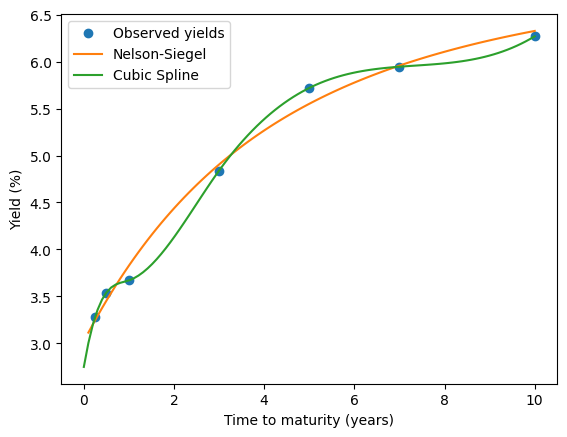

In [33]:
# Initial guess for NS parameters
params_guess = [2.0, 1.0, 0.5, 2.0]

# Optimize NS parameters using least squares
result_ns = least_squares(residual, params_guess, args=(t, y))

# Print the optimized NS parameters with names
beta0, beta1, beta2, tau = result_ns.x
print(f"Optimized Nelson-Siegel parameters: beta0={beta0}, beta1={beta1}, beta2={beta2}, tau={tau}")

# Create a Cubic Spline object
cs = CubicSpline(t, y)

# Generate fitted yield curves
t_plot = np.linspace(0, 10, 100)
y_plot_ns = ns_model(t_plot, beta0, beta1, beta2, tau)
y_plot_cs = cs(t_plot)

# Plot observed yields and fitted yield curves
plt.plot(t, y, 'o', label='Observed yields')
plt.plot(t_plot, y_plot_ns, label='Nelson-Siegel')
plt.plot(t_plot, y_plot_cs, label='Cubic Spline')
plt.xlabel('Time to maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()

#### Alternative: Polynomial Regression
Not to smooth data
Explain the data better
and what consist Polynomial Regression

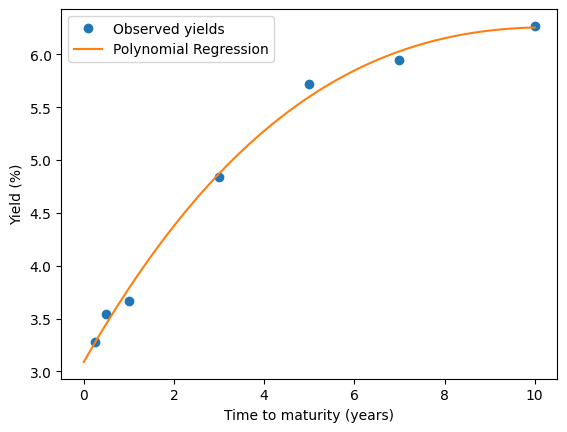

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Prepare the data
X = t.reshape(-1, 1)
y = y

# Create polynomial features
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions
t_plot = np.linspace(0, 10, 100).reshape(-1, 1)
t_plot_poly = poly.transform(t_plot)
y_plot_poly = model.predict(t_plot_poly)

# Plot observed yields and fitted yield curves
plt.plot(t, y, 'o', label='Observed yields')
plt.plot(t_plot, y_plot_poly, label='Polynomial Regression')
plt.xlabel('Time to maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()
